# 9.6.1 Support Vector Classifier

The `e1071` library contains an implementation for SVMs. In particular, the `svm()` function can be used to fit a support vector classifier using the argument `kernel= "linear"`.  

The implementation in `e1071` uses a `cost` argument that allows a cost for a violation to the margin. When the `cost` argument is small, then the margins are wide, and many support vectors will be on the margin or will violate the margin. When the `cost` argument is large then the margins will narrow and there will be few support vectors on the margin or violating the margin.

We begin by generating observations, which belong to one of two classes, and checking whether the classes are linearly separable.

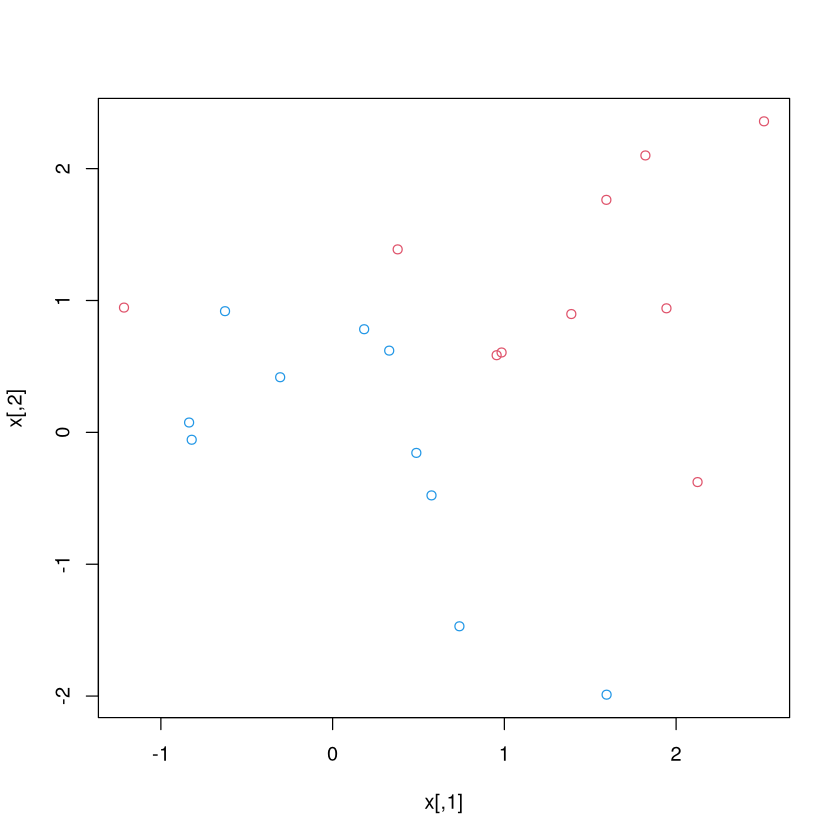

In [1]:
set.seed(1)
x <- matrix(rnorm(20*2), ncol = 2)
y <- c(rep(-1, 10), rep(1, 10))
x[y == 1,] <- x[y == 1,] + 1
plot(x, col = (3 - y))

They are not. Nex we fit the support vector classifier. Note that in order for the `svm()` function to perform classification (as opposed to SVM-based regression), we must encode the response as a factor variable. We now create a data frame with the response coded as a factor.

In [2]:
dat <- data.frame(x = x, y = as.factor(y))
library(e1071)
svmfit <- svm(y ~ ., data = dat, kernel = "linear", cost = 10, scale = F)

The argument `scale = F` tells the `svm()` function not to scale each feature to have mean zero or standard deviation one; depending on the application, one migh prefer to use `scale = T`.

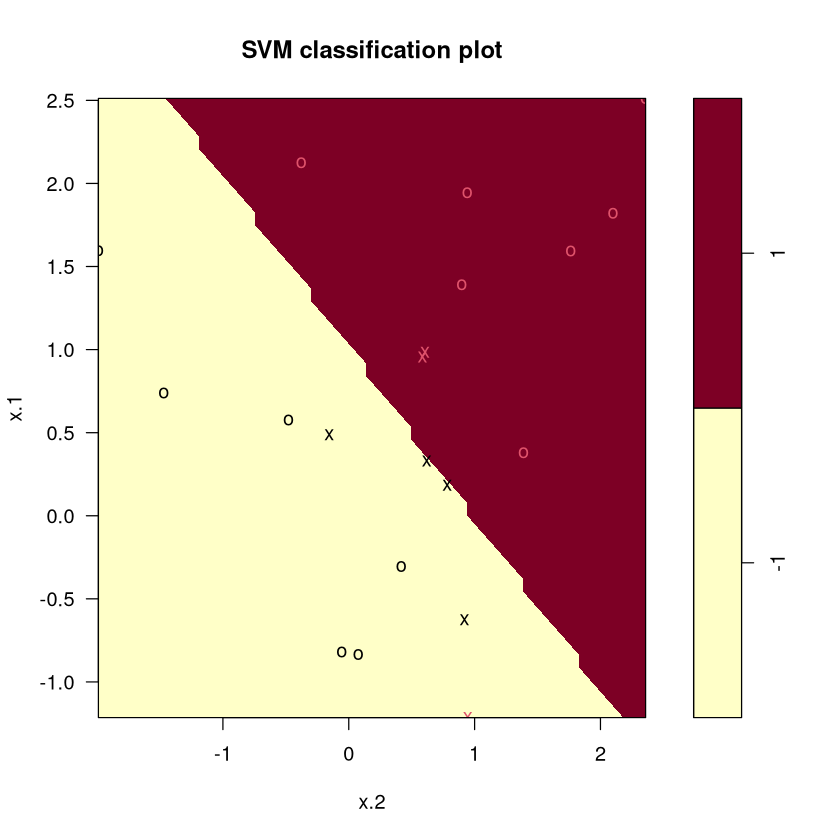

In [3]:
plot(svmfit, dat)

Note that the two arguments to the SVM `plot()` function are the output of the call to `svm()`, as well as the data used in the call to `svm()`.

The region of feature space that will be assigned to the $-1$ class is shown in light yellow, and the region that will be assigned to the $+1$ class is shown in red. The decision boundary between the two classes is linear (because we used the argument `kernel = "linear"`), though due to the way in which the plotting function is implmeented in this library the decision boundary looks somewhat jagged in the plot.

Note that here the second feature is plotted on the $x$-axis and the first feature is plotted on the $y$-axis, in contrast to the usual behavior of the `plot()` function.

The support vectors are plotted as crosses and the remaining observations are plotted as circles; we see here that there are seven support vectors. We can determine their identities as follows:

In [4]:
svmfit$index

[1]  1  2  5  7 14 16 17

Some basic information about the support vector classifier can be obtained using `summary()`

In [5]:
summary(svmfit)


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 10, scale = F)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




This tells us that a linear kernel was used with `cost = 10`, and that there were seven support vectors, four in one class and three in the other.

If we use a smaller value for the cost parameter?

[1]  1  2  3  4  5  7  9 10 12 13 14 15 16 17 18 20

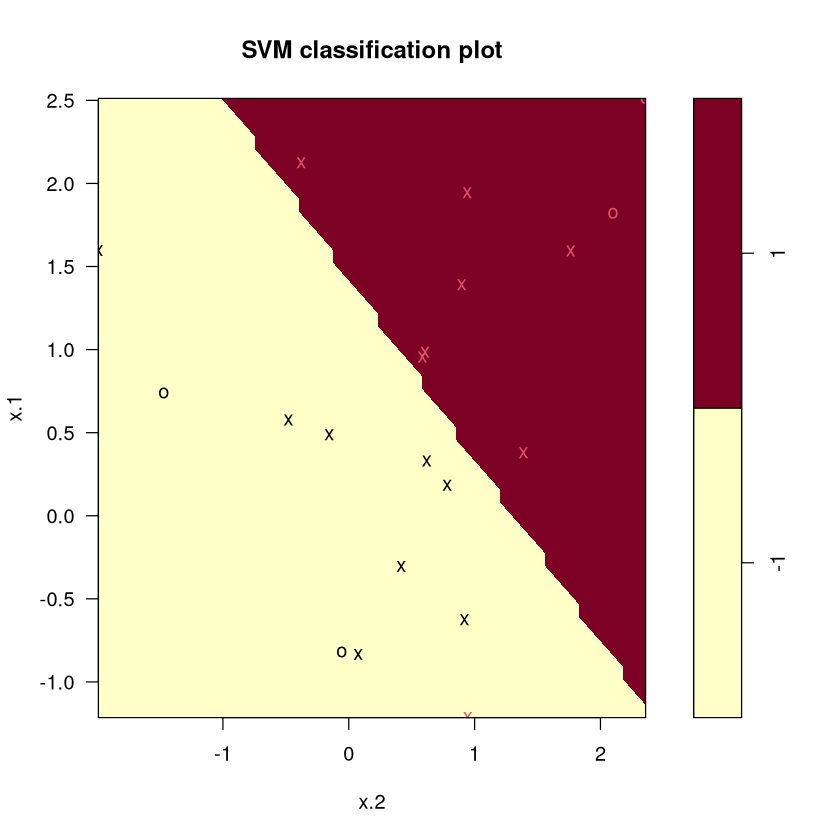

In [6]:
svmfit <- svm(y ~ ., data = dat, kernel = "linear", cost = 0.1, scale = F)
plot(svmfit, dat)
svmfit$index

Because we use a smaller value for the cost, we obtain more support vectors. This is because the margin is wider. Unfortuantely, the `svm()` function does not explicitly output the coefficients of the linear decision boundary obtained when the support vector classifier is fit, nor does it output the width of the margin.

The `e1071` library includes a built-in function, `tune()`, to perform cross-validation. By default, `tune()` performs ten-fold cross-validation on a set of models of interest. In order to use this function, we pass in relevant information about hte set of models that are under consideration. The following command indicates that we want to compare SVMs with a linear kernel, using a range of values of the `cost` parameter.

In [7]:
set.seed(1)
tune.out <- tune(svm, y ~ ., data = dat, kernel = "linear", ranges = list(cost = c(0.001, 0.01, 0.1, 1, 5, 10, 100)))

We can easily access the cross-validation errors for each of these models using the `summary()` command

In [8]:
summary(tune.out)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.05 

- Detailed performance results:
   cost error dispersion
1 1e-03  0.55  0.4377975
2 1e-02  0.55  0.4377975
3 1e-01  0.05  0.1581139
4 1e+00  0.15  0.2415229
5 5e+00  0.15  0.2415229
6 1e+01  0.15  0.2415229
7 1e+02  0.15  0.2415229


We can see that the `cost = 0.1` result is the lowest cross-validation error rate. The `tune()` function stores the best model obtained, which can be accessed as follows:

In [9]:
bestmod <- tune.out$best.model
summary(bestmod)


Call:
best.tune(METHOD = svm, train.x = y ~ ., data = dat, ranges = list(cost = c(0.001, 
    0.01, 0.1, 1, 5, 10, 100)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.1 

Number of Support Vectors:  16

 ( 8 8 )


Number of Classes:  2 

Levels: 
 -1 1




The `predict()` function can be used to predict the class label on a set of test observations, at any given value of the cost parameter. We begin by generating a test data set.

In [10]:
xtest <- matrix(rnorm(20*2), ncol = 2)
ytest <- sample(c(-1, 1), 20, rep = T)
xtest[ytest == 1,] <- xtest[ytest == 1,] + 1
testdat <- data.frame(x = xtest, y = as.factor(ytest))

Now we predict the class labels of these test observations. Here we use the best model obtained through cross-validation in order to make predictions.

In [11]:
ypred <- predict(bestmod, testdat)
table(predict = ypred, truth = testdat$y)

       truth
predict -1 1
     -1  9 1
     1   2 8

Thus, with this value of `cost`, $17$ of the test observations are correctly classified. What if we had instead used `cost = 0.01`?

In [12]:
svmfit <- svm(y ~ ., data = dat, kernel = "linear", cost = .01, scale = F)
ypred <- predict(svmfit, testdat)
table(predict = ypred, truth = testdat$y)

       truth
predict -1  1
     -1 11  6
     1   0  3

In this case three additional observations are misclassified.

Now consider a situation in which the two classes are linearly separable. Then we can find a separating hyperplane using the `svm()` function. We first further separate the two classes in our simualted data so that they are linearly separable:

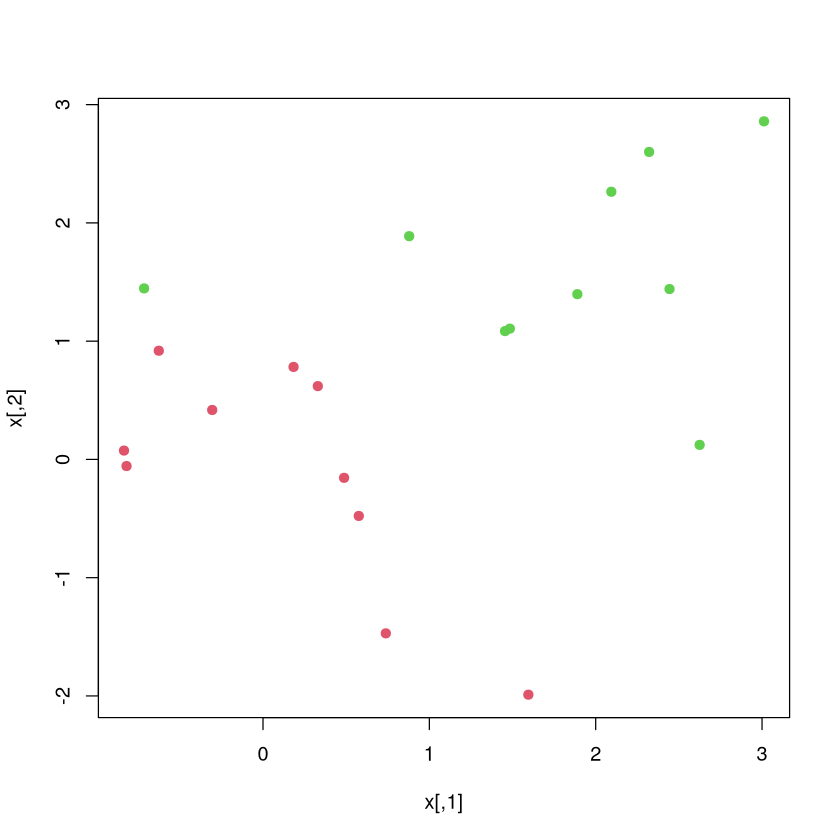

In [13]:
x[y == 1,] <- x[y == 1,] + 0.5
plot(x, col = (y + 5) / 2, pch = 19)

Now the observations are just barely linearly separable. We fit the support vector classifier and plot the resulting hyperplane, using a very large value of `cost` so that no observations are misclassified.


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 1e+05)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1e+05 

Number of Support Vectors:  3

 ( 1 2 )


Number of Classes:  2 

Levels: 
 -1 1




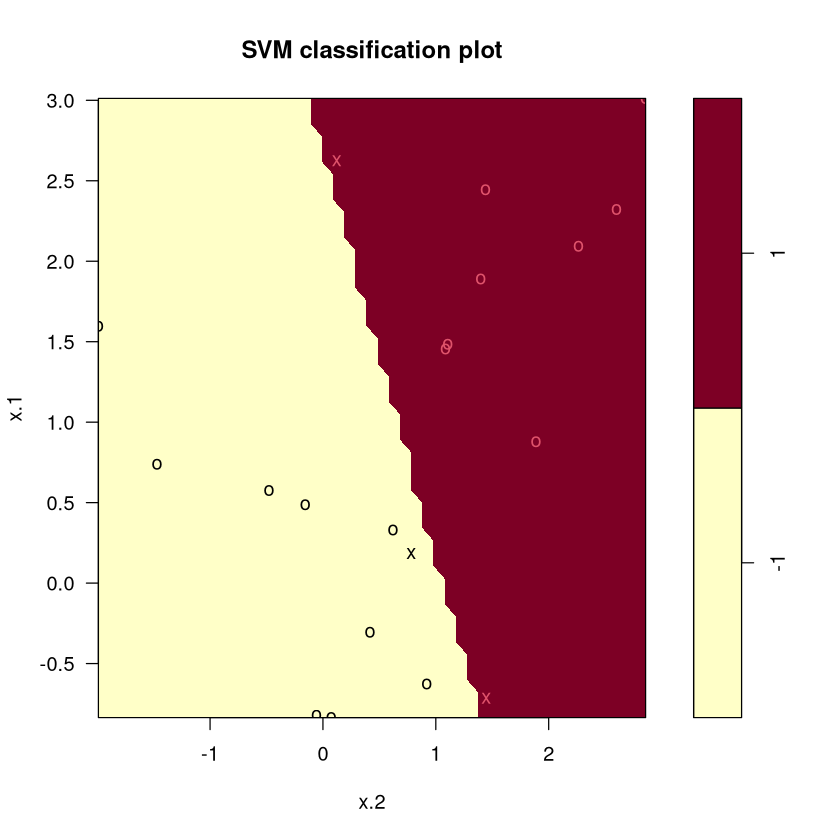

In [14]:
dat <- data.frame(x = x, y = as.factor(y))
svmfit <- svm(y ~ ., data = dat, kernel = "linear", cost = 1e5)
summary(svmfit)
plot(svmfit, dat)

No training errors were made and only three support vectors were used. However, we can see from the figure that the margin is very narrow (because the observations that are not support vectors, indicated as circles, are very close to the decision boundary). It seems likely that this model will perform poorly on test data. We now try a smaller value of `cost`:


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




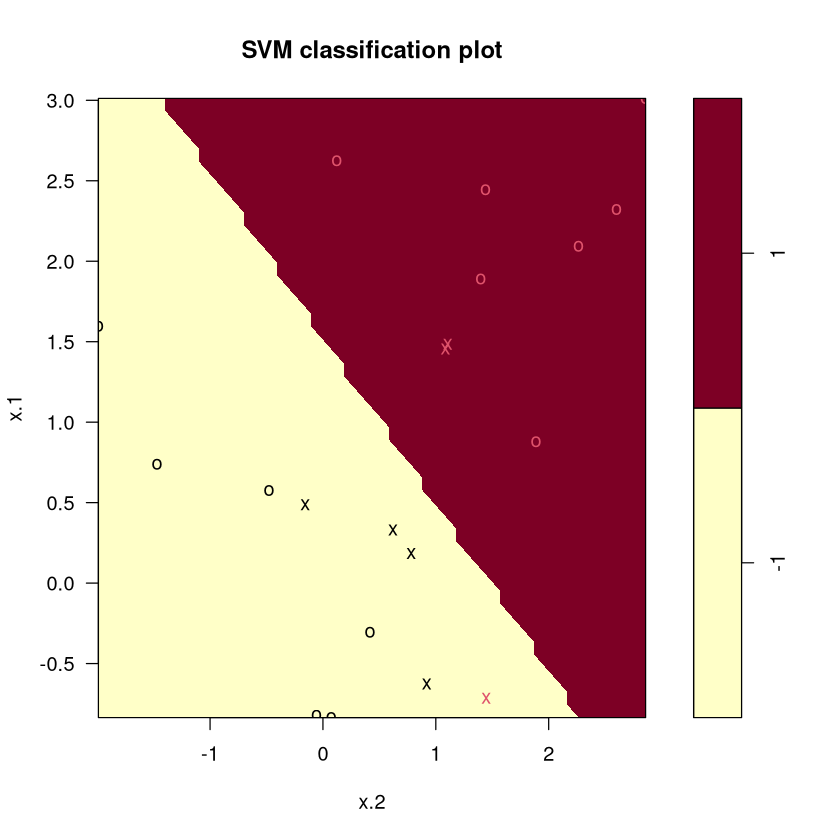

In [15]:
svmfit <- svm(y ~ ., data = dat, kernel = "linear", cost = 1)
summary(svmfit)
plot(svmfit, dat)

Using `cost = 1`, we misclassify a training observation, but we also obtain a much wider margin and make use of seven support vectors. It seems likely that this model will perform better on test data than the model with `cost = 1e5`.